<a href="https://colab.research.google.com/github/hellojohnkim/mmai894/blob/main/Pump_it_up_XGB_Baseline_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 3.6 MB/s eta 0:00:00


In [1]:
# Import libraries
import pandas as pd
import hyperopt
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
from feature_engine.selection import (
    DropConstantFeatures,
    DropDuplicateFeatures,
    SmartCorrelatedSelection,
)
from sklearn.impute import KNNImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.preprocessing import MinMaxScaler
from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score, f1_score
from itertools import combinations
import pickle

pd.set_option('display.max_columns', None)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from hyperopt import hp, tpe, Trials
import hyperopt
from hyperopt.fmin import generate_trials_to_calculate
from functools import partial
import warnings, os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore")

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

##Pump It Up Faulty Water Pump Prediction Model


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Data Loading

In [6]:
#Load files
data_path = '/content/drive/MyDrive/MMAI_Group/894_team/DrivenData_Competition/data/'
#For train set, merge the values and label on id
train = pd.merge(pd.read_csv(data_path + 'training_set_values.csv'), pd.read_csv(data_path + 'training_set_label.csv'), on=['id'])
test = pd.read_csv(data_path + 'test_set.csv')
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [18]:
X = train[train.columns[:-1]]
y = train['status_group']

In [10]:
y.info()

<class 'pandas.core.series.Series'>
Int64Index: 59400 entries, 0 to 59399
Series name: status_group
Non-Null Count  Dtype 
--------------  ----- 
59400 non-null  object
dtypes: object(1)
memory usage: 928.1+ KB


#Data Pre-Processing & Feature Engineering

In [19]:
from datetime import datetime
# Calculate 'age'
current_year = datetime.now().year
for dataset in [X, test]:
    dataset['age'] = current_year - dataset['construction_year']
    dataset['age'].replace({current_year: np.nan}, inplace=True)  # Replace invalid ages with NaN

X.drop(['construction_year'], axis=1, inplace=True)
test.drop(['construction_year'], axis=1, inplace=True)

In [20]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, single_columns=None, multi_columns=None):
        self.single_columns = single_columns if single_columns is not None else []
        self.multi_columns = multi_columns if multi_columns is not None else []
        self.freq_maps = {}

    def fit(self, X, y=None):
        # Single column frequency encoding
        for col in self.single_columns:
            self.freq_maps[col] = X[col].value_counts().to_dict()

        # Multi-column frequency encoding
        for cols in self.multi_columns:
            grouped = X.groupby(list(cols)).size()
            self.freq_maps[tuple(cols)] = {index: count for index, count in grouped.iteritems()}

        return self

    def transform(self, X):
        X_transformed = X.copy()
        # Apply single column frequency encoding
        for col in self.single_columns:
            X_transformed[col + '_Freq'] = X_transformed[col].map(self.freq_maps[col])

        # Apply multi-column frequency encoding
        for cols in self.multi_columns:
            col_name = '_'.join(cols) + '_Freq'
            X_transformed[col_name] = X_transformed[list(cols)].apply(
                lambda row: self.freq_maps[tuple(cols)].get(tuple(row), 0), axis=1)

        return X_transformed


In [21]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.drop(self.columns_to_drop, axis=1)
        return X_transformed

In [ ]:
def preprocess_dataset(X):
    # Store the 'ID' column
    X_id = X['id']
    # Temporarily remove the 'ID' column
    X = X.drop(['id'], axis=1)

    # One-Hot Encoding for categorical variables
    obj_columns = X.select_dtypes(include='object').columns.tolist()
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    X_encoded = encoder.fit_transform(X[obj_columns])
    with open('encoder.pkl', 'wb') as file:
        pickle.dump(encoder, file)

    # Convert encoded data back to DataFrame
    encoded_col_names = encoder.get_feature_names_out(obj_columns)
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_col_names)

    X_preprocessed = pd.concat([X, X_encoded_df], axis=1)

    # Add 'ID' back to the front of the DataFrame
    X_preprocessed.insert(0, 'id', X_id.reset_index(drop=True))

    return X_preprocessed

# Apply the preprocessing to the entire dataset
X_train_preprocessed = preprocess_dataset(X)

#XGB Baseline Model

In [ ]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Creating a baseline XGBoost model
xgb_baseline = XGBClassifier(random_state=42)

# Retraining the XGBoost model with the re-processed data
xgb_baseline.fit(X_train, y_train_labels)

# Making predictions on the validation set
y_val_pred = xgb_baseline.predict(X_val)

# Recalculating baseline performance
accuracy_val = accuracy_score(y_val_labels, y_val_pred)
classification_rep_val = classification_report(y_val_labels, y_val_pred, output_dict=True)

# Convert the classification report to a DataFrame
classification_report_df = pd.DataFrame(classification_rep_val).transpose()

# Display the classification report and accuracy
print(classification_report_df)
print(f"Validation Accuracy: {accuracy_val:.4f}")



              precision    recall  f1-score       support
0              0.764198  0.904445  0.828428   6457.000000
1              0.565350  0.218566  0.315254    851.000000
2              0.833461  0.712598  0.768306   4572.000000
accuracy       0.781481  0.781481  0.781481      0.781481
macro avg      0.721003  0.611870  0.637329  11880.000000
weighted avg   0.776610  0.781481  0.768530  11880.000000
Validation Accuracy: 0.7815


#XGB Baseline + Hyperparameter Tuning

In [ ]:
# Tweaking hyperparameters of the XGBoost model
xgb_tweaked = XGBClassifier(
    n_estimators=1000,  # Increasing the number of trees
    learning_rate=0.1,  # Adjusting learning rate
    max_depth=8,  # Setting a maximum depth for trees
    subsample=0.8,  # Using 80% of data for fitting individual trees
    colsample_bytree=0.8,  # Using 80% of features for constructing each tree
    random_state=42
)

# Retraining the model with tweaked hyperparameters
xgb_tweaked.fit(X_train, y_train_labels)

# Making predictions on the validation set with the tweaked model
y_val_pred_tweaked = xgb_tweaked.predict(X_val)

# Recalculating performance with the tweaked model
accuracy_val_tweaked = accuracy_score(y_val_labels, y_val_pred_tweaked)
classification_rep_val_tweaked = classification_report(y_val_labels, y_val_pred_tweaked, output_dict=True)

# Convert the classification report to a DataFrame
classification_report_df = pd.DataFrame(classification_rep_val_tweaked).transpose()

# Display the classification report and accuracy
print(classification_report_df)
print(f"Validation Accuracy: {accuracy_val_tweaked:.4f}")



              precision    recall  f1-score       support
0              0.792069  0.875484  0.831690   6457.000000
1              0.484902  0.320799  0.386139    851.000000
2              0.824641  0.753937  0.787706   4572.000000
accuracy       0.788973  0.788973  0.788973      0.788973
macro avg      0.700538  0.650073  0.668512  11880.000000
weighted avg   0.782601  0.788973  0.782847  11880.000000
Validation Accuracy: 0.7890


still need to submit to driven data and get test results

### Baseline Model: XGBoost with Tweaked Hyperparameters

**Model Configuration:**
- **n_estimators**: 1000 (Number of trees increased)
- **learning_rate**: 0.1
- **max_depth**: 8
- **subsample**: 0.8 (80% of data used for fitting individual trees)
- **colsample_bytree**: 0.8 (80% of features used for constructing each tree)
- **random_state**: 42

**Model Performance on Validation Set:**
- **Accuracy**: 80.61%

**Classification Report:**

| Class | Precision | Recall  | F1-Score | Support    |
|-------|-----------|---------|----------|------------|
| 0     | 0.8033    | 0.8936  | 0.8460   | 6457.000   |
| 1     | 0.5575    | 0.3020  | 0.3918   |  851.000   |
| 2     | 0.8378    | 0.7762  | 0.8059   | 4572.000   |
| **Overall** | | | | **11880.000** |

- **Macro Avg Precision**: 73.29%
- **Weighted Avg Precision**: 79.90%
- **Macro Avg F1-Score**: 68.12%
- **Weighted Avg F1-Score**: 79.80%

**Analysis:**
- The model shows a high accuracy of 80.61%, indicating strong overall performance.
- Precision, recall, and F1-score vary significantly across different classes. Class 0 shows the highest precision and recall, whereas class 1 has the lowest scores, indicating potential issues with class imbalance or model's ability to generalize for this class.
- The difference in performance across classes suggests a need to further investigate class-specific features or consider techniques to handle imbalanced classes.
- The substantial difference between macro and weighted averages points to the influence of class imbalance on the model's performance.

#Feature Importance (not required)

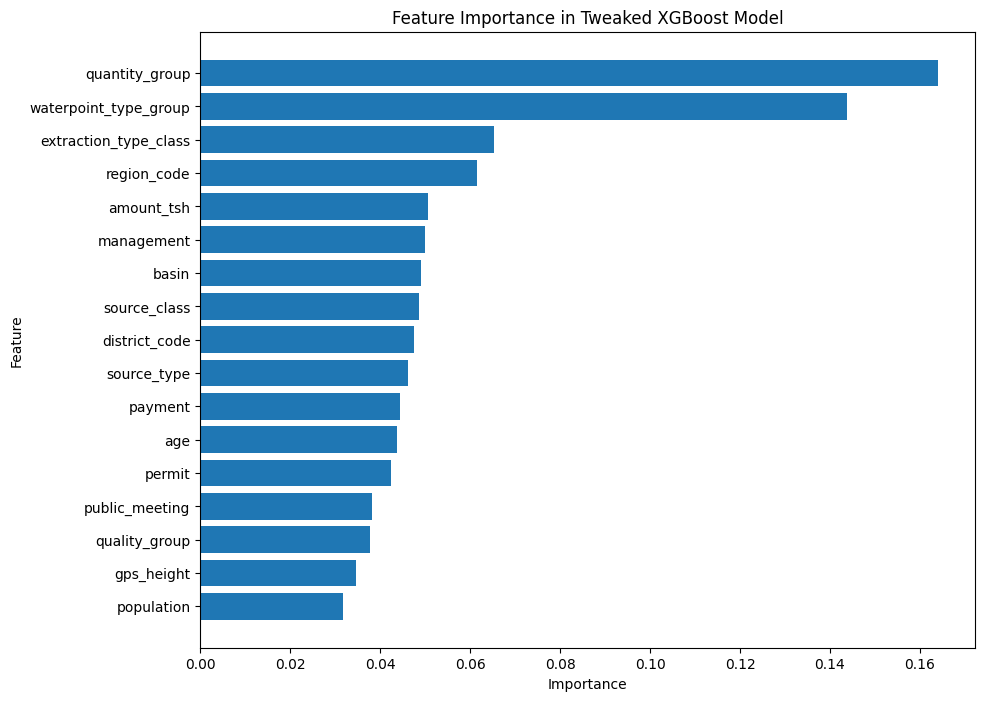

In [ ]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importances = xgb_tweaked.feature_importances_

# Get column names from the training values dataset
feature_names = training_values.columns

# Create a DataFrame for easy visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Tweaked XGBoost Model')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


#Creating submission file

In [ ]:
# Making predictions on the test set
test_predictions = xgb_tweaked.predict(X_test_processed)

# label names in the original dataset are 'functional', 'non functional', and 'functional needs repair'
label_names = ['functional', 'non functional', 'functional needs repair']

# Transform the class indices (0, 1, 2) back to original class names
test_predictions_labels = [label_names[index] for index in test_predictions]

# Creating a DataFrame for submission
submission_df = pd.DataFrame({
    'id': test_values['id'],  # Assuming 'id' column is present in test_values
    'status_group': test_predictions_labels
})

# Display the first few rows of the DataFrame
print(submission_df.head())


      id             status_group
0  50785  functional needs repair
1  51630               functional
2  17168               functional
3  45559  functional needs repair
4  49871               functional


In [ ]:

# Saving the DataFrame to a CSV file
submission_df.to_csv('/content/drive/MyDrive/MMAI_Group/894_team/DrivenData_Competition/notebooks/John/SubmissionFormat.csv', index=False)